In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import statsmodels.graphics.gofplots as sgg
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
%matplotlib inline

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be r

In [2]:
my_data = pd.read_csv('/home/lin/教材/Financial_data/data/finance_M4/my_fx_data', header = None, usecols = [1], names = ['price'])

In [3]:
my_data.head()

,price
0,4915.1
1,4867.6
2,4679.8
3,4595.8
4,4609.2


In [4]:
my_data.describe()

,price
count,4197.000000
mean,8665.180105
std,2891.102233
min,3613.400000
25%,5867.900000
50%,8626.700000
75%,10569.800000
max,15178.000000


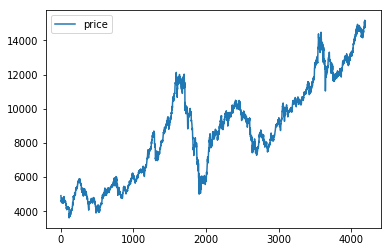

In [5]:
my_data.plot()

In [6]:
logR = np.log(my_data).diff()
logR.head()

,price
0,NaN
1,-0.009711
2,-0.039346
3,-0.018113
4,0.002911


In [7]:
logR.values

array([[        nan],
       [-0.0097111 ],
       [-0.03934563],
       ...,
       [ 0.00020826],
       [ 0.00679489],
       [ 0.00697432]])

In [8]:
logR.drop(logR.index[0], inplace = True)

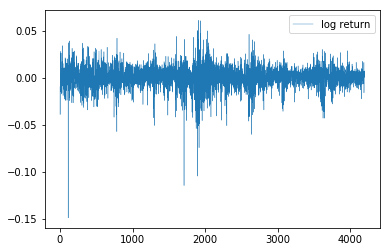

In [9]:
#%matplotlib tk
logR.plot(linewidth = 0.4)
plt.legend(['log return'])
plt.show()

In [10]:
logR.describe()

,price
count,4196.000000
mean,0.000267
std,0.012079
min,-0.149340
25%,-0.005606
50%,0.000742
75%,0.006732
max,0.060968


In [11]:
stats.skew(logR['price'])

-1.1502129828839347

In [12]:
stats.kurtosis(logR['price'])

11.260451026283784

In [13]:
adfuller(logR['price']) #test for stationary

(-23.262701610140457,
 0.0,
 6,
 4189,
 {'1%': -3.4319120223653132,
  '10%': -2.5671374076308826,
  '5%': -2.8622302155703507},
 -24993.19087817247)

In [14]:
stats.anderson(logR['price']) #test for normal distribution

AndersonResult(statistic=44.06294861250717, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [15]:
numSmoothingFactor = 900
#this guy should be a input to the optimized bin number function, it should also take nomalized data
scores = np.zeros(numSmoothingFactor)
binNums = range(1,numSmoothingFactor + 1)
for binNum in binNums:
    frequen, binEdges = np.histogram(logR, bins = binNum)
    numObser = logR['price'].count().astype(float)
    proEst = frequen / numObser
    sumFreqSqua = np.sum(proEst ** 2)
    score = ((2. * binNum) / ( numObser - 1.)) - (sumFreqSqua * (numObser + 1.) * binNum/ (numObser - 1.))
    scores[binNum - 1] = score

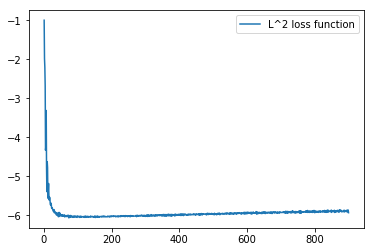

In [16]:
plt.plot(binNums, scores)
plt.legend(['L^2 loss function'])

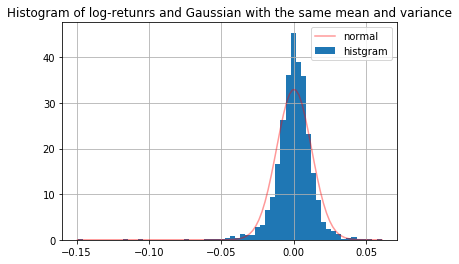

In [17]:
numbins = int(60) 
logR.hist(bins = numbins, normed=True)


mu_log = np.mean(logR['price'])
sigma_log = np.std(logR['price'])
x_ticks = np.linspace(min(logR['price']), max(logR['price']),100)
plt.plot(x_ticks, 1./((2.*np.pi)**0.5 *sigma_log)*np.exp(-((x_ticks - mu_log)/sigma_log)**2/2), 'r', alpha = 0.4)
plt.title('Histogram of log-retunrs and Gaussian with the same mean and variance')
plt.legend(['normal', 'histgram'])

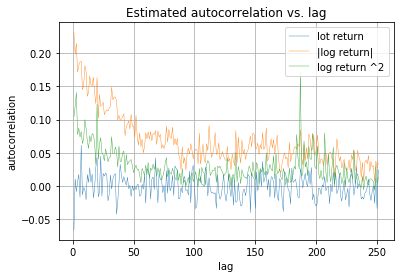

In [18]:
autocorr_logR = [logR['price'].autocorr(lag=_) for _ in range(1,252)]
autocorr_abs_logR = [abs(logR['price']).autocorr(lag=_) for _ in range(1,252)]
autocorr_sqLogR = [(logR['price'] ** 2).autocorr(lag=_) for _ in range(1,252)]
plt.plot(range(1, 252),autocorr_logR, range(1, 252), autocorr_abs_logR, range(1, 252), autocorr_sqLogR, linewidth = 0.4)
plt.title('Estimated autocorrelation vs. lag')
plt.legend(['lot return', '|log return|', 'log return ^2'], loc = 1)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.grid(True)
plt.show()

In [19]:
posiR = logR[logR > 0].dropna()
negaR = logR[logR <= 0].dropna()

In [20]:
np.unique(posiR > 0)

array([ True])

In [21]:
np.unique(negaR <= 0)

array([ True])

In [22]:
sortedPosiR = posiR['price'].sort_values()
sortedNegaR = (-negaR['price']).sort_values()
numObs = logR['price'].count()

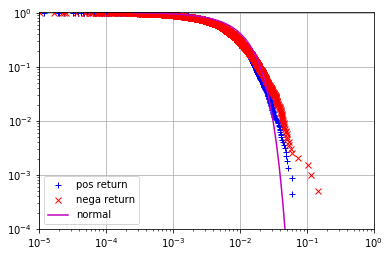

In [23]:
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b')
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr')
domain = np.linspace(mu_log, max(abs(logR['price'])), 1000)
plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.5) * 2, 'm')
plt.ylim([1e-4, 1.05])
plt.xlim([1e-5, 1])
plt.legend(['pos return', 'nega return', 'normal'], loc = 3)
plt.grid(True)

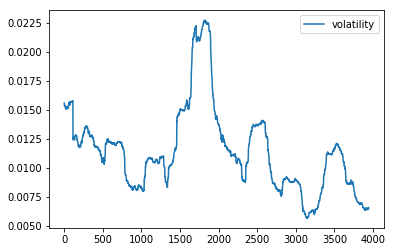

In [24]:
window = 252
cumlogR = logR['price'].cumsum()
cumlogRSq = (logR['price'] ** 2).cumsum()
sqRunAvg = (cumlogRSq[cumlogRSq.index[window :]].values - cumlogRSq[cumlogRSq.index[: cumlogRSq.count() - window]].values)/window
RuningAvg = (cumlogR[cumlogR.index[window :]].values - cumlogR[cumlogR.index[: cumlogR.count() - window]].values)/window
volatility = np.sqrt(sqRunAvg - RuningAvg ** 2)
plt.figure()
plt.plot(volatility)
plt.legend(['volatility'])

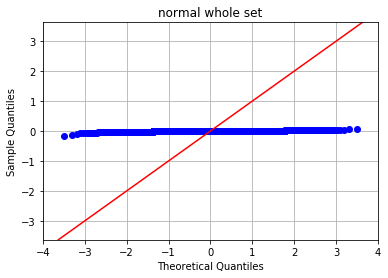

In [25]:
normal_para = [mu_log, sigma_log]

sgg.qqplot(logR['price'], stats.norm, fit = False, line = '45', loc = mu_log, scale = sigma_log)
plt.title('normal whole set')
plt.xlim([-4, 4])
plt.grid(True)

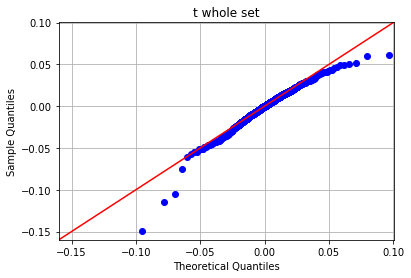

In [28]:
t_para = stats.t.fit(logR['price'], loc = mu_log, scale = sigma_log)
sgg.qqplot(logR['price'], stats.t, fit = False, line = '45',distargs = t_para)
plt.title('t whole set')
plt.grid(True)

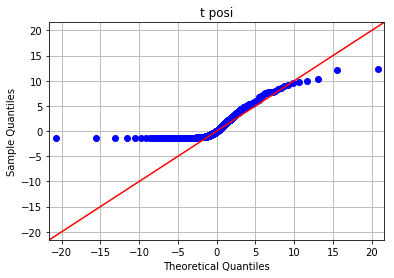

In [29]:
posi_t_para = stats.t.fit(posiR['price'])
sgg.qqplot(posiR['price'], stats.t, fit = True, line = '45',distargs = posi_t_para)
plt.title ('t posi')
plt.grid(True)

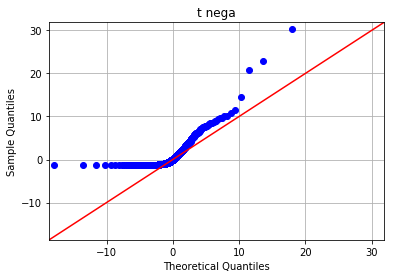

In [30]:
nega_t_para = stats.t.fit(-negaR['price'])
sgg.qqplot(-negaR['price'], stats.t, fit = True, line = '45',distargs = nega_t_para)
plt.title('t nega')
plt.grid(True)

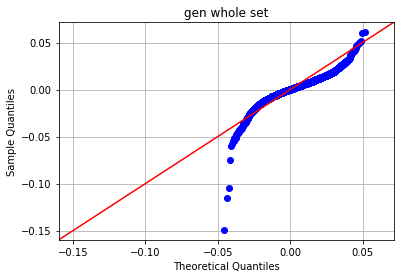

In [31]:
gen_para = stats.genextreme.fit(logR['price'], loc = mu_log, scale = sigma_log)
#gen_para = list(gen_para)
#gen_para[0] = gen_para[0] * (-1)

# it's this one

loc, scale = gen_para[1:]
fake_distargs = (gen_para[0],)

pp = sgg.ProbPlot(logR['price'], dist=stats.genextreme, distargs=gen_para, fit=False)
fig = pp.qqplot(line='45')
plt.title('gen whole set')
plt.grid(True)

In [ ]:
gen_para

In [ ]:
plt.plot(logR['price'].sort_values(), stats.genextreme.cdf(logR['price'].sort_values(), c =gen_para[0] , loc = gen_para[1], scale = gen_para[2]), linewidth = 0.4)
plt.plot(logR['price'].sort_values(), stats.norm.cdf(logR['price'].sort_values(), mu_log, sigma_log), linewidth = 0.4)

In [ ]:
posi_gen_para = stats.genextreme.fit(posiR['price'])
sgg.qqplot(posiR['price'], stats.genextreme, fit = True, line = '45',distargs = posi_gen_para)
plt.title('gen posi')
plt.grid(True)

In [ ]:
nega_gen_para = stats.genextreme.fit(-negaR['price'])
sgg.qqplot(-negaR['price'], stats.genextreme, fit = True, line = '45',distargs = nega_gen_para)
plt.title('gen nega')
plt.grid(True)

In [ ]:
domain = np.linspace(mu_log, max(abs(logR['price'])), 1000)
plt.figure()
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b')
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr')
plt.loglog(domain, 1 - (stats.genextreme.cdf(domain, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2]) - 0.485 + 0.012 ) * 2, 'm')
plt.loglog(domain, 1 - (stats.t.cdf(domain, df = t_para[0] , loc = t_para[1], scale = t_para[2]) - 0.479 + 0.012 ) * 2, '--b')
plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.5 + 0.012 ) * 2, 'y')
plt.title('posi nega data with parametric distibutinos')
plt.legend(['posi lreturn', 'nega lreturn', 'gen', 't','normal'])
plt.ylim([1e-4, 1.2])

In [ ]:
plt.figure()
plt.plot(domain, (stats.genextreme.pdf(domain, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2])) * 2, 'm')
plt.plot(domain, (stats.t.pdf(domain, df = t_para[0] , loc = t_para[1], scale = t_para[2])) * 2, '--b')
plt.plot(domain, (stats.norm.pdf(domain, mu_log, sigma_log)) * 2, 'y')

In [ ]:
#%matplotlib inline
#%matplotlib qt
numbins = int(60) 
logR.hist(bins = numbins, normed=True)


mu_log = np.mean(logR['price'])
sigma_log = np.std(logR['price'])
x_ticks = np.linspace(min(logR['price']), max(logR['price']),100)
plt.plot(x_ticks, 1./((2.*np.pi)**0.5 *sigma_log)*np.exp(-((x_ticks - mu_log)/sigma_log)**2/2), 'r', alpha = 0.4)
plt.plot(x_ticks, (stats.genextreme.pdf(x_ticks, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2])), 'm', alpha = 0.4)
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = t_para[0] , loc = t_para[1], scale = t_para[2])), '--b', alpha = 0.5)
#plt.plot(logR_grid, pdf, '--r')


In [ ]:
domain = np.linspace(max(abs(logR['price']))/1000, max(abs(logR['price'])), 1000)
plt.loglog(domain, 1 - (stats.genextreme.cdf(domain, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2]) - 0.48) * 2, 'm')
plt.loglog(domain, 1 - (stats.genextreme.cdf(domain, c =posi_gen_para[0] , loc = posi_gen_para[1], scale = posi_gen_para[2]) - 0.03), '--r')
plt.loglog(domain, 1 - (stats.genextreme.cdf(domain, c =nega_gen_para[0] , loc = nega_gen_para[1], scale = nega_gen_para[2]) - 0.03), '--b')
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b')
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr')
plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.5) * 2, 'y')
plt.title('compare gen fited with whole set with fited with halves')
plt.legend(['gen whole set', 'gen posi', 'gen nega', 'posi data', 'nega data', 'normal'])
plt.ylim([4e-4, 1.05])

In [ ]:
plt.loglog(domain, 1 - (stats.genextreme.cdf(domain, c = gen_para[0] * (-1) , loc = gen_para[1], scale = gen_para[2]) * 2), 'm')
#plt.loglog(domain, 1 / domain ** (1 / gen_para[0]))

In [ ]:
 from scipy.stats import genextreme
mean, var, skew, kurt = genextreme.stats(-gen_para[0], moments='mvsk')
kurt

In [ ]:
%matplotlib tk
domain = np.linspace(max(abs(logR['price']))/1000, max(abs(logR['price'])), 1000)
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =t_para[0] , loc = t_para[1], scale = t_para[2]) - 0.48) * 2, 'm')
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =posi_t_para[0] , loc = posi_t_para[1], scale = posi_t_para[2]) - 0.15), '--r')
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2]) - 0.15), '--b')
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b')
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr')
plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.5) * 2, 'y')
plt.title('compare t fited with whole set with fited with halves')
plt.legend(['t whole set', 't posi', 't nega', 'posi data', 'nega data', 'normal'])
#plt.ylim([4e-1, 1.05])

In [ ]:
#what is this magical * 2 thing? Should I do it for all the fitted distribution for the whole set of data while plot with 
#halves? why distribution fitted with halves match worse than fitted with whole? Data points? still 2000+
#lay out of report

In [ ]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.0001, 0.002, 50)},
                    cv=10) 
grid.fit(logR['price'][:, None])
kde = grid.best_estimator_
print (grid.best_params_)

In [ ]:
logR_grid = np.linspace(min(logR['price']) - 0.05, max(logR['price']) + 0.05, 1000)
pdf = np.exp(kde.score_samples(logR_grid[:, None]))
plt.figure()
plt.plot(logR_grid, pdf)

In [ ]:
plt.get_backend()